In [1]:
# @title: imports, and graphics setup
import sys
sys.path.append('..')
from multiprocessing import Pool, TimeoutError
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline
import matplotlib.colors as mcol
import matplotlib.cm as cm
import numpy as np
import scipy.stats as stats
from scipy.optimize import curve_fit
from scipy import integrate as integrate
from Modules.custom_simulations import simulate_particles_in_external_force_Not_HOOMD
import mpmath as mp
import warnings
from scipy.optimize import fsolve
from tqdm.auto import tqdm, trange
from Modules.pdfs import *
from joblib import Parallel, delayed
import re

%matplotlib inline
matplotlib.style.use('default')
matplotlib_inline.backend_inline.set_matplotlib_formats('png')

In [2]:
from Modules.potentials import harmonic_potential
from Modules.forces import harmonic_force

In [3]:
def run_simulation(n_particles, steps, x_start_position, force ,force_args, delta_fraction,dt, kT, gamma):
    start_position=x_start_position
    args = [force, n_particles, steps, delta_fraction]
    trajectories = simulate_particles_in_external_force_Not_HOOMD(*args, dt=dt, kT=kT, force_args=force_args, start_position=start_position, gamma=gamma, type=np.float16)
    x_positions = np.array(trajectories)
    return x_positions

### r $\neq$ 0

In [8]:
### Simulation Parameters ###
dt = 0.1
gamma = 500
kT = 1
steps = 10000
n_particles = 15000
batch_size = 7500
batches = int(n_particles/batch_size)
D=kT/gamma


### Harmonic Potential Parameters ###
k_harms = np.linspace(1, 20, 10)
force_args_s = [[k] for k in k_harms]

typical_relaxation_times = gamma/k_harms

typical_length_scales = np.sqrt(D*typical_relaxation_times)

### resetting parameters ### 
delta_fraction = 0.002
resetting_rate = delta_fraction/dt
print('Resetting rate -', resetting_rate)
start_position = 0
sherf_nums = gamma*resetting_rate/k_harms

k_harms_str = [f'{rate:.0f}' for rate in k_harms]
k_harms_str = ','.join(k_harms_str)
folder = f'HarmonicPotentialTrajectories/K-{k_harms_str}'
external_drive_path = None
if external_drive_path is not None:
    os.makedirs(os.path.join(external_drive_path, folder), exist_ok=True)
    external_folder_resetting = os.path.join(external_drive_path, folder)
else:
    os.makedirs(folder, exist_ok=True)
    external_folder_resetting = folder

print('Sherf numbers -', sherf_nums)
print('Folder -', folder)
trajectories_per_k = None

Resetting rate - 0.02
Sherf numbers - [10.          3.21428571  1.91489362  1.36363636  1.05882353  0.86538462
  0.73170732  0.63380282  0.55900621  0.5       ]
Folder - HarmonicPotentialTrajectories/K-1,3,5,7,9,12,14,16,18,20


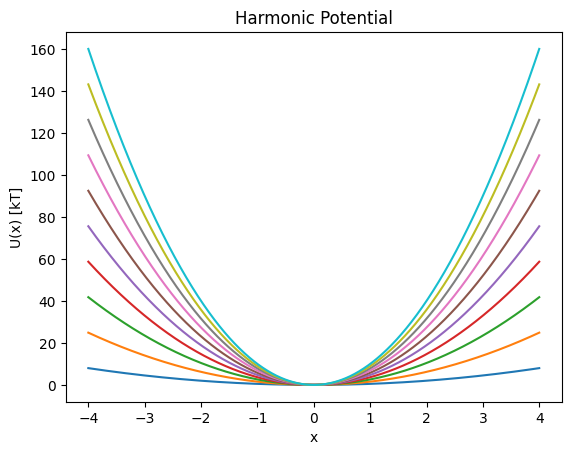

In [6]:
### plot potential ###
potential_x = np.linspace(-4, 4, 1000)
potential_y_s = [harmonic_potential(potential_x, k)/kT for k in k_harms]
for potential_y in potential_y_s:
    plt.plot(potential_x, potential_y)
plt.xlabel('x')
plt.ylabel('U(x) [kT]')
plt.title('Harmonic Potential')
plt.show()

In [7]:
import mpl_toolkits.axes_grid1 as axes_grid
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Make a user-defined colormap.
cm1 = mcol.LinearSegmentedColormap.from_list("MyCmapName",["b","b","y","y","orange","orange","orange","r","r"])

# Make a normalizer that will map the time values from
# [start_time,end_time+1] -> [0,1].
cnorm = mcol.Normalize(vmin=min(np.abs(k_harms)),vmax=max(np.abs(k_harms)))

# Turn these into an object that can be used to map time values to colors and
# can be passed to plt.colorbar().
cpick = cm.ScalarMappable(norm=cnorm,cmap=cm1)

colors = [cpick.to_rgba(np.abs(start_pos)) for start_pos in k_harms]

In [10]:
### Run simulations ###
#raise KeyboardInterrupt
print([int(a) for a in np.arange(0 , n_particles, batch_size)])
os.makedirs(external_folder_resetting, exist_ok=True)
filenames = os.listdir(external_folder_resetting)
existing_batches = 0
for file in filenames:
    if re.search("^batch.*npy", file):
        nums = re.findall((r'\d+'), file)
        n = ''.join(nums)
        if int(n) > existing_batches:
            existing_batches = int(n)
print("Existing Batches: ", existing_batches)
if __name__ == "__main__":
    for _ in np.arange(0 , n_particles, batch_size):
        print(_)
        simulation_parameters = [(batch_size, steps, start_position, harmonic_force, force_args, delta_fraction, dt, kT, gamma) for force_args in force_args_s]
        trajectories_per_start = Parallel(n_jobs=-2, verbose = 1, backend='loky')(delayed(run_simulation)(*args) for args in simulation_parameters)
        np.save(external_folder_resetting+f'/batch_{int(_/batch_size)+1+existing_batches}.npy', trajectories_per_start)
        print(f'Finished {_+batch_size} particles')
    print('Finished all particles')

[0, 7500]
Existing Batches:  0
0


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   8 out of  10 | elapsed:    7.4s remaining:    1.8s
[Parallel(n_jobs=-2)]: Done  10 out of  10 | elapsed:    7.8s finished


Finished 7500 particles
7500


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   8 out of  10 | elapsed:    6.8s remaining:    1.6s
[Parallel(n_jobs=-2)]: Done  10 out of  10 | elapsed:    7.3s finished


Finished 15000 particles
Finished all particles


In [12]:
if trajectories_per_k is None:
    filenames = os.listdir(external_folder_resetting)
    trajectories = np.load(external_folder_resetting+'/'+filenames[0])
    trajectories_per_k = np.array(trajectories)
    del trajectories
else:
    print('Using existing trajectories_per_k')

Using existing trajectories_per_k


In [13]:
def _calculate_single_mean_var(x_pos):
    mean = np.mean(x_pos, axis=1)
    var = np.var(x_pos, axis=1)
    return mean, var

def calculate_mean_var_trajectory_per_k(trajs):
    means_vars_per_pos = []
    for x_pos in trajs:
        means_vars_per_pos.append(_calculate_single_mean_var(x_pos))
    return np.array(means_vars_per_pos)

def calculate_average_measure_per_batches(folder, measure, batches=-1, args=[]):
    if batches == 0:
        return None
    c = 0
    for filename in os.listdir(folder):
        if filename.endswith('.npy') and filename[0:5] == 'batch':
            trajectories_per_r = np.array(np.load(folder+'/'+filename)) 
            if c == 0:
                value = measure(trajectories_per_r, *args)
            else:
                value += measure(trajectories_per_r, *args)
            c+=1
            if batches != -1 and batches == c:
                break
            del trajectories_per_r
            print(f'finished batch {c} of {batches}')
    return value/c

In [14]:
means_vars = calculate_average_measure_per_batches(folder, calculate_mean_var_trajectory_per_k, batches=3)
means = means_vars[:, 0]
vars = means_vars[:, 1]
del means_vars

finished batch 1 of 3
finished batch 2 of 3


In [15]:
np.save(folder+'/mean_trajectories.npy', means)
np.save(folder+'/var_trajectories.npy', vars)

In [16]:
means = np.load(folder+'/mean_trajectories.npy')
vars = np.load(folder+'/var_trajectories.npy')

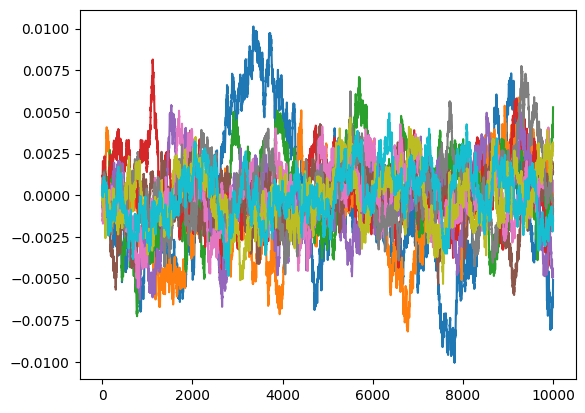

In [17]:
### plot mean per k ### 
for k,mean_traj in zip(k_harms,means):
    plt.plot(mean_traj)
plt.show()

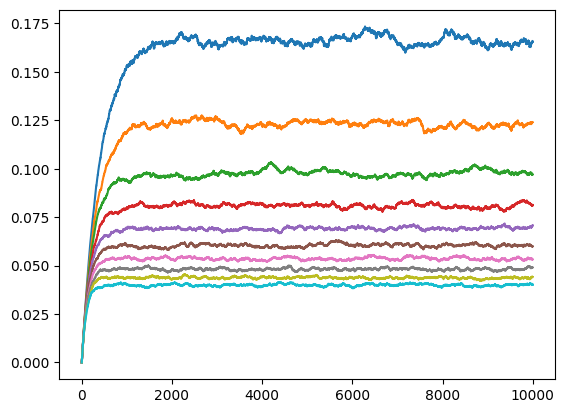

In [18]:
### plot vars per start ### 
for k,vars_traj in zip(k_harms,vars):
    plt.plot(vars_traj)
plt.show()

In [19]:
samples_in_ss = 500
ss_vars = []
for k, var_per_k in zip(k_harms, vars):
    ss_vars.append(np.mean(var_per_k[-samples_in_ss:]))

In [20]:
### Histograms using the same bins NO BATCHES ###
samples = 5
target_distribution_samples = 500
steady_state = 7000
timesteps = np.arange(0, steady_state, 10)
histograms_per_k = []
min_bin = np.min(trajectories_per_k[0][-samples:])
max_bin = np.max(trajectories_per_k[0][-samples:])
bin_edges = np.linspace(min_bin, max_bin, 201)
bins = bin_edges*1.2

In [21]:
### Histograms using the same bins NO BATCHES ###

def _calculate_single_histogram(x_pos, bins, timesteps, n_samples, n_target_distribution_samples):
    histograms_per_timestep = []
    target_distribution_points = x_pos[-n_target_distribution_samples:]
    target_distribution, _ = np.histogram(target_distribution_points, bins=bins, density=True)
    for timestep in timesteps:
        if timestep != 0:
            histogram, bin_edges = np.histogram(x_pos[timestep:timestep+n_samples], bins=bins, density=True)
        else:
            histogram, bin_edges = np.histogram(x_pos[timestep:timestep+1], bins=bins, density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        histograms_per_timestep.append([histogram, bin_centers])
    histograms_per_timestep.append([target_distribution, bin_centers])
    return histograms_per_timestep

def generate_histograms_per_k(trajs, bins, timesteps, n_samples, n_target_distribution_samples):
    histograms_per_k = Parallel(n_jobs=-1, prefer='threads')(delayed(_calculate_single_histogram)(x_pos, bins, timesteps, n_samples, n_target_distribution_samples) for x_pos in trajs)
    histograms_per_k = np.array(histograms_per_k)
    return histograms_per_k

In [22]:
args = [bins, timesteps, samples, target_distribution_samples]
histograms_per_k = calculate_average_measure_per_batches(external_folder_resetting, generate_histograms_per_k, args=args, batches=-1)

finished batch 1 of -1
finished batch 2 of -1


In [23]:
np.save(external_folder_resetting+f'/histograms_per_k.npy', histograms_per_k)

In [ ]:
histograms_per_k = np.load(external_folder_resetting+f'/histograms_per_k.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'HarmonicPotentialTrajectories/K-1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20/histograms_per_k.npy'

0it [00:00, ?it/s]

0.9999997787998145
1.000035634678214
1.0000191219063148
1.000009287657526
1.000033874825809
1.0000184046682192
1.0000207217750186
1.000008212490549
1.0000197644823596
1.0000237473273663


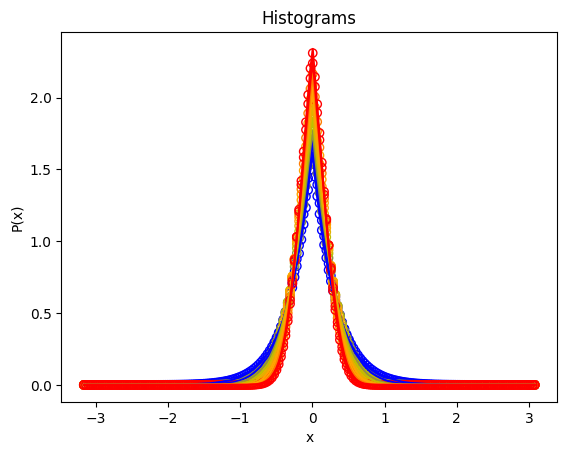

In [24]:
### plot histograms at ss ###
for i, (histograms_per_time, k, c) in tqdm(enumerate(zip(histograms_per_k, k_harms, colors))):
    hist, bin_centers = histograms_per_time[-1]
    bin_centers_centralized = bin_centers - np.mean(bin_centers)
    print(np.trapezoid(hist, bin_centers))
    plt.plot(bin_centers, hist, label=f'{k_harms[i]:.3f}', color=c)
    pdf = lambda x: pdf_resetting_in_harmonic_potential(x, k, resetting_rate*dt, shift=0, dt=dt, kT=kT, gamma=gamma)
    plt.scatter(bin_centers, pdf(bin_centers), label=f'{k:.3f}', color=c, marker='o', facecolors='none')
plt.xlabel('x')
plt.ylabel('P(x)')
plt.title('Histograms')
plt.show()

#### Calc KLDs

In [26]:
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

In [27]:
# Make a user-defined colormap.
color_list = ["b","b","y","y","orange","orange","orange","r","r"]
cm1 = mcol.LinearSegmentedColormap.from_list("MyCmapName",color_list[::-1])

# Make a normalizer that will map the time values from
# [start_time,end_time+1] -> [0,1].
normalized_k_s = gamma/np.array(k_harms)
cnorm_normlized = mcol.Normalize(vmin=min(np.abs(normalized_k_s)),vmax=max(np.abs(normalized_k_s)))

# Turn these into an object that can be used to map time values to colors and
# can be passed to plt.colorbar().
cpick_normlized = cm.ScalarMappable(norm=cnorm_normlized,cmap=cm1)

colors_normlized = [cpick_normlized.to_rgba(np.abs(k)) for k in normalized_k_s]
print(normalized_k_s)

[500.         160.71428571  95.74468085  68.18181818  52.94117647
  43.26923077  36.58536585  31.69014085  27.95031056  25.        ]


In [28]:
total_batches = 0
for filename in os.listdir(external_folder_resetting):
    if filename.endswith('.npy') and filename[0:5] == 'batch':
        total_batches += 1
print('Total Batches: ', total_batches)

Total Batches:  2


In [29]:
### Characterize Steady State Index of the KLDs using batches to estimate error bars ###
histograms_per_BKT = [] #Batch Start Time
samples = 5
target_distribution_samples = 500
steady_state = 7000
timesteps = np.arange(0, steady_state, 5)
for i in tqdm(range(total_batches)):
    histograms_per_ST = []
    for filename in os.listdir(external_folder_resetting):
        check_if_batch_file =  re.search("^batch"and"\\.npy$", filename) != None
        batch_found = ''.join(re.findall(r'\d', filename))
        if check_if_batch_file and batch_found == str(i+1):
            trajectories = np.load(external_folder_resetting+'/'+filename)
            trajectories_per_k = np.array(trajectories)
            del trajectories
            break
    histograms_per_ST = generate_histograms_per_k(trajectories_per_k, bins, timesteps, samples, target_distribution_samples)
    del trajectories_per_k
    histograms_per_BKT.append(histograms_per_ST)
    print(f'Finished batch {i+1} of {total_batches}')
histograms_per_BKT = np.array(histograms_per_BKT)

  0%|          | 0/2 [00:00<?, ?it/s]

Finished batch 1 of 2
Finished batch 2 of 2


In [30]:
np.save(external_folder_resetting+f'/histograms_per_BKT.npy', histograms_per_BKT)

In [31]:
histograms_per_BKT = np.load(external_folder_resetting+f'/histograms_per_BKT.npy')

In [33]:
### Calculate KLDs per rate ###
#raise KeyboardInterrupt
KLDs_per_BK = []
for i, histograms_per_ST in tqdm(enumerate(histograms_per_BKT)):
    KLDs_per_S = []
    for histograms_per_time, k_harm in zip(histograms_per_ST, k_harms):
        KLDs_by_TS = []
        shift = 0
        x_intercept = 0
        delta_fraction = resetting_rate*dt
        harmonic_pdf_args = [k_harm, delta_fraction, shift, dt, kT, gamma, x_intercept]
        eps = 1e-10
        pdf_values = histograms_per_time[-1][0] + eps

        for hist, bin_centers in histograms_per_time[:-1]:
            hist = hist + eps
            kld = stats.entropy(pdf_values, hist)
            KLDs_by_TS.append(kld)
        


        KLDs_by_TS = np.array(KLDs_by_TS)
        nans, x = nan_helper(KLDs_by_TS)
        if np.sum(nans) != 0:
            KLDs_by_TS[nans] = np.interp(x(nans), x(~nans), np.array(KLDs_by_TS)[~nans])
        KLDs_per_S.append(KLDs_by_TS)
    KLDs_per_S = np.array(KLDs_per_S)
    KLDs_per_BK.append(KLDs_per_S)
KLDs_per_BK = np.array(KLDs_per_BK)

0it [00:00, ?it/s]

In [ ]:
np.save(external_folder_resetting+f'/KLDs_per_BK.npy', KLDs_per_BK)

In [34]:
samples = 5
target_distribution_samples = 500
steady_state = 7000
KLDs_per_BK = np.load(external_folder_resetting+f'/KLDs_per_BK.npy')
timesteps = np.arange(0, steady_state, samples)

(2, 10, 1400)
(10, 1400)


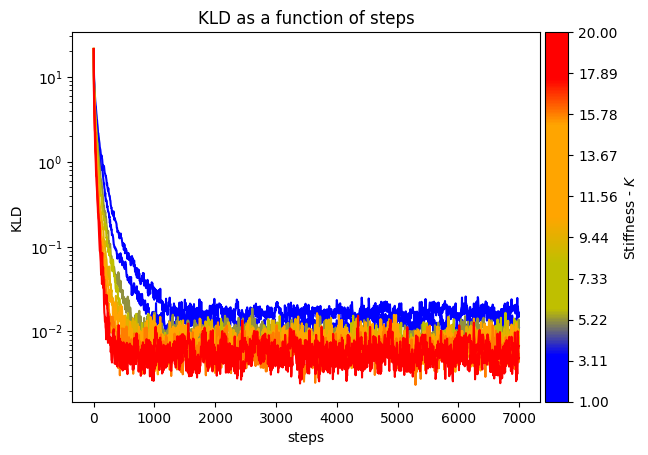

In [35]:
import mpl_toolkits.axes_grid1 as axes_grid
from mpl_toolkits.axes_grid1 import make_axes_locatable


print(KLDs_per_BK.shape)
KLDs_per_k = np.mean(KLDs_per_BK, axis=0)
print(KLDs_per_k.shape)
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
for kld_per_time, k_harm, c in zip(KLDs_per_k, k_harms, colors):
    im = ax.semilogy(timesteps,kld_per_time, label=f'{k_harm:.3f}', color=c)
fig.colorbar(cpick, cax=cax, label='Stiffness - $K$', ticks=k_harms)
ax.set_xlabel('steps')
ax.set_ylabel('KLD')
ax.set_title('KLD as a function of steps')
plt.show()

KLD threshold: 0.06001183458723021
KLD threshold: 0.04983482419873487


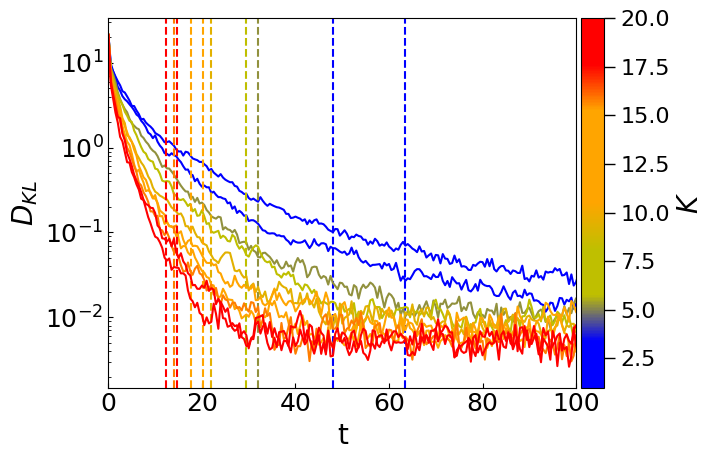

In [36]:
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
timesteps = np.arange(0, steady_state, 5)



platue_indices_per_r = []
for klds_per_batch in KLDs_per_BK:
    platue_index_per_r = []
    kld_thresholds = []
    for kld_per_time in klds_per_batch:
        kld_threshold = np.mean(kld_per_time[-100:])
        kld_threshold_std = np.std(kld_per_time[-100:])
        kld_threshold = kld_threshold + 10*kld_threshold_std
        kld_thresholds.append(kld_threshold)
    kld_threshold = np.max(kld_thresholds)
    print('KLD threshold:', kld_threshold)
    for i, (kld_per_time, k, c) in enumerate(zip(klds_per_batch, k_harms, colors)):
        platue_index = np.where(kld_per_time < kld_threshold)[0][0]
        timestep_platue = timesteps[platue_index]*dt
        platue_index_per_r.append(timestep_platue)
    platue_indices_per_r.append(platue_index_per_r)
platue_indices_per_r = np.array(platue_indices_per_r)
mean_platue_indices_per_r = np.mean(platue_indices_per_r, axis=0)
std_platue_indices_per_r = np.std(platue_indices_per_r, axis=0)

for i, (kld_per_time, platue, k, c) in enumerate(zip(KLDs_per_k, mean_platue_indices_per_r, k_harms, colors)):
    adjusted_timesteps = timesteps*dt
    im=ax.semilogy(adjusted_timesteps,kld_per_time, label=f'{k:.3f}', color=c)
    im=ax.axvline(platue, color=c, linestyle='--')
cbar = fig.colorbar(cpick, cax=cax, label='$K$', orientation='vertical',ticklocation='right')
cbar.ax.tick_params(labelsize=16, direction='out', length=8, width=1)
cbar.ax.set_ylabel('$K$', fontsize=20)
kld_line_handle = plt.Line2D([0],[0],linestyle='-',color='Black', label='KLD')
platue_index_handle = plt.Line2D([0],[0],linestyle='--',color='Black', label=f'$\\tau_R$')
resetting_rate_handles = []
for k, c in zip(k_harms, colors):
    h = plt.bar([0],[0],color=c,label=f'$x_0$={k:.3f}')
    resetting_rate_handles.append(h)
handles = [kld_line_handle, platue_index_handle] + resetting_rate_handles
ax.set_xlabel('t', fontsize=20)
ax.set_ylabel('$D_{KL}$',fontsize=20)
ax.tick_params(axis='both', which='both', labelsize=18, direction='in')
ax.set_xlim(0, 100)
plt.show()

In [37]:
np.save(external_folder_resetting+f'/mean_platue_indices_per_K.npy', mean_platue_indices_per_r)
np.save(external_folder_resetting+f'/std_platue_indices_per_K.npy', std_platue_indices_per_r)
np.save(external_folder_resetting+f'/k_harms.npy', np.array(k_harms))

### Refernce no resetting Systems

In [47]:
### Simulation Parameters ###
dt = 0.1
gamma = 500
kT = 1
steps = 10000
n_particles = 15000
batch_size = 7500
batches = int(n_particles/batch_size)
D=kT/gamma


### Harmonic Potential Parameters ###
k_harms = np.linspace(1, 20, 10)
force_args_s = [[k] for k in k_harms]

typical_relaxation_times = gamma/k_harms

typical_length_scales = np.sqrt(D*typical_relaxation_times)

### resetting parameters ### 
delta_fraction = 0
resetting_rate = delta_fraction/dt
start_position = 0
sherf_nums = gamma*resetting_rate/k_harms

k_harms_str = [f'{rate:.0f}' for rate in k_harms]
k_harms_str = ','.join(k_harms_str)
folder = f'HarmonicPotentialTrajectories/K_r_0-{k_harms_str}'
external_drive_path = None
if external_drive_path is not None:
    os.makedirs(os.path.join(external_drive_path, folder), exist_ok=True)
    external_folder = os.path.join(external_drive_path, folder)
else:
    os.makedirs(folder, exist_ok=True)
    external_folder = folder
print('Sherf numbers -', sherf_nums)
print('Folder -', folder)

trajectories_per_k = None

Sherf numbers - [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Folder - HarmonicPotentialTrajectories/K_r_0-1,3,5,7,9,12,14,16,18,20


In [48]:
import mpl_toolkits.axes_grid1 as axes_grid
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Make a user-defined colormap.
cm1 = mcol.LinearSegmentedColormap.from_list("MyCmapName",["b","b","y","y","orange","orange","orange","r","r"])

# Make a normalizer that will map the time values from
# [start_time,end_time+1] -> [0,1].
cnorm = mcol.Normalize(vmin=min(np.abs(k_harms)),vmax=max(np.abs(k_harms)))

# Turn these into an object that can be used to map time values to colors and
# can be passed to plt.colorbar().
cpick = cm.ScalarMappable(norm=cnorm,cmap=cm1)

colors = [cpick.to_rgba(np.abs(start_pos)) for start_pos in k_harms]

In [49]:
### Run simulations ###
#raise KeyboardInterrupt
print([int(a) for a in np.arange(0 , n_particles, batch_size)])
os.makedirs(external_folder, exist_ok=True)
filenames = os.listdir(external_folder)
existing_batches = 0
for file in filenames:
    if re.search("^batch.*npy", file):
        nums = re.findall((r'\d+'), file)
        n = ''.join(nums)
        if int(n) > existing_batches:
            existing_batches = int(n)
print("Existing Batches: ", existing_batches)

if __name__ == "__main__":
    for _ in np.arange(0 , n_particles, batch_size):
        simulation_parameters = [(batch_size, steps, start_position, harmonic_force, force_args, delta_fraction, dt, kT, gamma) for force_args in force_args_s]
        trajectories_per_k = Parallel(n_jobs=-2, verbose = 1, backend='loky')(delayed(run_simulation)(*args) for args in simulation_parameters)
        np.save(external_folder+f'/batch_{int(_/batch_size)+1+existing_batches}.npy', trajectories_per_k)
        print(f'Finished {_+batch_size} particles')
    print('Finished all particles')


[0, 7500]
Existing Batches:  0


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   8 out of  10 | elapsed:    4.7s remaining:    1.1s
[Parallel(n_jobs=-2)]: Done  10 out of  10 | elapsed:    5.1s finished


Finished 7500 particles


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   8 out of  10 | elapsed:    4.8s remaining:    1.1s
[Parallel(n_jobs=-2)]: Done  10 out of  10 | elapsed:    5.3s finished


Finished 15000 particles
Finished all particles


In [50]:
if trajectories_per_k is None:
    filenames = os.listdir(external_folder)
    trajectories = np.load(external_folder+'/'+filenames[0])
    print(filenames[0])
    trajectories_per_k = np.array(trajectories)
    del trajectories
else:
    print('Using existing trajectories_per_k')

Using existing trajectories_per_k


In [51]:
means_vars = calculate_average_measure_per_batches(external_folder, calculate_mean_var_trajectory_per_k, batches=2)
means = means_vars[:, 0]
vars = means_vars[:, 1]
del means_vars

finished batch 1 of 2


In [52]:
np.save(folder+'/mean_trajectories.npy', means)
np.save(folder+'/var_trajectories.npy', vars)

In [53]:
means = np.load(folder+'/mean_trajectories.npy')
vars = np.load(folder+'/var_trajectories.npy')

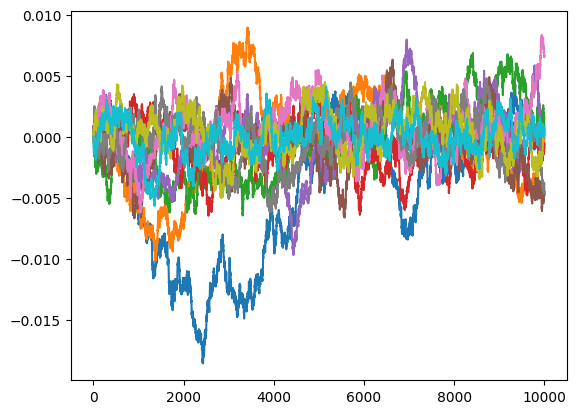

In [54]:
### plot mean per k ### 
for k,mean_traj in zip(k_harms,means):
    plt.plot(mean_traj)
plt.show()

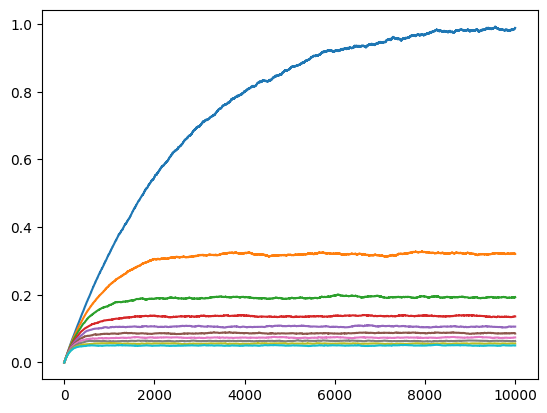

In [56]:
### plot vars per start ### 
for k,vars_traj in zip(k_harms,vars):
    plt.plot(vars_traj)
plt.show()

In [57]:
### Histograms using the same bins NO BATCHES ###
samples = 5
target_distribution_samples = 500
steady_state = 8000
timesteps = np.arange(0, steady_state, samples)
histograms_per_k = []
min_bin = np.min(trajectories_per_k[0][-samples:])
max_bin = np.max(trajectories_per_k[0][-samples:])
bin_edges = np.linspace(min_bin, max_bin, 201)
bins = bin_edges*1.2

In [58]:
# no batches analysis
c = 0
for filename in os.listdir(external_folder):
    if filename.endswith('.npy') and filename[0:5] == 'batch':
        trajectories = np.load(external_folder+'/'+filename)
        trajectories_per_k= np.array(trajectories) 
        if c == 0:
            histograms_per_k = generate_histograms_per_k(trajectories_per_k, bins, timesteps, samples, target_distribution_samples)
        else:
            histograms_per_k += generate_histograms_per_k(trajectories_per_k, bins, timesteps, samples, target_distribution_samples)
        c+=1
histograms_per_k = histograms_per_k/c

0.9999635478088527


e:\Nir\Simulations\Stochastic Resetting - Faster Relaxation, Different Destination\FasterRelaxationDifferentDestination\Modules\pdfs.py:22: RuntimeWarning: divide by zero encountered in scalar divide
  p = b/resetting_param #                  |unitless


ValueError: gamma function pole

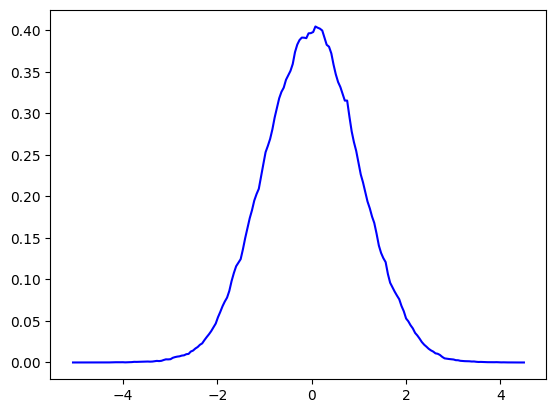

In [59]:
### plot histograms at ss ###
for i, (histograms_per_time, k, c) in enumerate(zip(histograms_per_k, k_harms, colors)):
    hist, bin_centers = histograms_per_time[-1]
    bin_centers_centralized = bin_centers - np.mean(bin_centers)
    print(np.trapezoid(hist, bin_centers))
    plt.plot(bin_centers, hist, label=f'{k_harms[i]:.3f}', color=c)
    pdf = lambda x: pdf_resetting_in_harmonic_potential(x, k, resetting_rate*dt, shift=0, dt=dt, kT=kT, gamma=gamma)
    plt.scatter(bin_centers, pdf(bin_centers), label=f'{k:.3f}', color=c, marker='o', facecolors='none')
plt.xlabel('x')
plt.ylabel('P(x)')
plt.title('Histograms')
plt.show()

In [60]:
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

In [61]:
# Make a user-defined colormap.
color_list = ["b","y","y","y","orange","orange","orange","r","r"]
cm1 = mcol.LinearSegmentedColormap.from_list("MyCmapName",color_list[::-1])

# Make a normalizer that will map the time values from
# [start_time,end_time+1] -> [0,1].
normalized_k_s = gamma/np.array(k_harms)
cnorm_normlized = mcol.Normalize(vmin=min(np.abs(normalized_k_s)),vmax=max(np.abs(normalized_k_s)))

# Turn these into an object that can be used to map time values to colors and
# can be passed to plt.colorbar().
cpick_normlized = cm.ScalarMappable(norm=cnorm_normlized,cmap=cm1)

colors_normlized = [cpick_normlized.to_rgba(np.abs(k)) for k in normalized_k_s]
print(normalized_k_s)

[500.         160.71428571  95.74468085  68.18181818  52.94117647
  43.26923077  36.58536585  31.69014085  27.95031056  25.        ]


In [62]:
total_batches = 0
for filename in os.listdir(external_folder):
    if filename.endswith('.npy') and filename[0:5] == 'batch':
        total_batches += 1
print('Total Batches: ', total_batches)

Total Batches:  2


In [63]:
### Characterize Steady State Index of the KLDs using batches to estimate error bars ###
histograms_per_BKT_boltz = [] #Batch Start Time
samples = 5
target_distribution_samples = 500
steady_state = 8000
timesteps = np.arange(0, steady_state, 5)
for i in tqdm(range(total_batches)):
    trajectories_per_k = None
    histograms_per_ST = []
    for filename in os.listdir(external_folder):
        check_if_batch_file =  re.search("^batch"and"\\.npy$", filename) != None
        batch_found = ''.join(re.findall(r'\d', filename))
        #if batch_found != '21':
        #    continue
        if check_if_batch_file and batch_found == str(i+1):
            print(filename)
            try:
                trajectories = np.load(external_folder+'/'+filename)
            except (FileNotFoundError, ValueError) as e:
                print(f'Could not read or cast data in File {filename}, skipping...')
                continue
            trajectories_per_k = np.array(trajectories)
            del trajectories
            break
    if trajectories_per_k is None:
        continue
    histograms_per_ST = generate_histograms_per_k(trajectories_per_k, bins, timesteps, samples, target_distribution_samples)
    del trajectories_per_k
    histograms_per_BKT_boltz.append(histograms_per_ST)
    print(f'Finished batch {i+1} of {total_batches}')
histograms_per_BKT_boltz = np.array(histograms_per_BKT_boltz)


  0%|          | 0/2 [00:00<?, ?it/s]

batch_1.npy
Finished batch 1 of 2
batch_2.npy
Finished batch 2 of 2


In [64]:
np.save(external_folder+'/histograms_per_BKT_boltz.npy', histograms_per_BKT_boltz)

In [65]:
### Calculate KLDs per rate ###
#raise KeyboardInterrupt
KLDs_per_BK_boltz = []
for i, histograms_per_KT in tqdm(enumerate(histograms_per_BKT_boltz)):
    KLDs_per_K = []
    for histograms_per_time, k_harm in zip(histograms_per_KT, k_harms):
        KLDs_by_TK = []
        shift = 0
        x_intercept = 0
        delta_fraction = resetting_rate*dt
        harmonic_pdf_args = [k_harm, delta_fraction, shift, dt, kT, gamma, x_intercept]
        eps = 1e-10
        pdf_values = histograms_per_time[-1][0] + eps


        for hist, bin_centers in histograms_per_time[:-1]:
            hist = hist + eps
            kld = stats.entropy(pdf_values, hist)
            KLDs_by_TK.append(kld)
        
        KLDs_by_TK = np.array(KLDs_by_TK)
        nans, x = nan_helper(KLDs_by_TK)
        if np.sum(nans) != 0:
            KLDs_by_TK[nans] = np.interp(x(nans), x(~nans), np.array(KLDs_by_TK)[~nans])
        KLDs_per_K.append(KLDs_by_TK)
    KLDs_per_K = np.array(KLDs_per_K)
    KLDs_per_BK_boltz.append(KLDs_per_K)
KLDs_per_BK_boltz = np.array(KLDs_per_BK_boltz)


0it [00:00, ?it/s]

In [66]:
np.save(external_folder+f'/KLDs_per_BK_boltz.npy', KLDs_per_BK_boltz)

In [67]:
steady_state = 8000
KLDs_per_BK_boltz = np.load(external_folder+f'/KLDs_per_BK_boltz.npy')
timesteps = np.arange(0, steady_state, 5)

(2, 10, 1600)
(10, 1600)


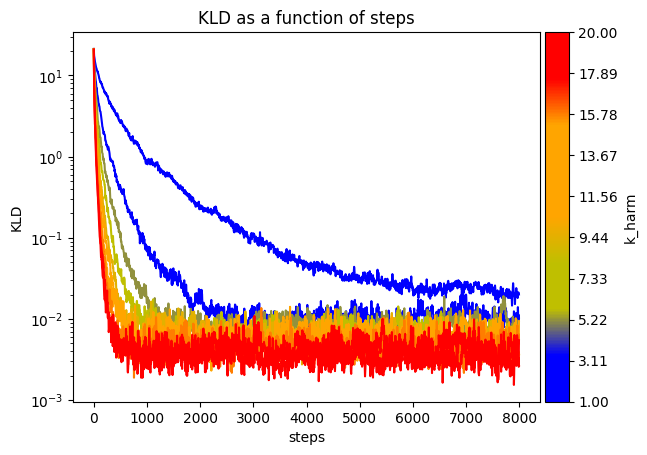

In [68]:
import mpl_toolkits.axes_grid1 as axes_grid
from mpl_toolkits.axes_grid1 import make_axes_locatable


print(KLDs_per_BK_boltz.shape)
KLDs_per_k_boltz = np.mean(KLDs_per_BK_boltz, axis=0)
print(KLDs_per_k_boltz.shape)
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
for kld_per_time, c in zip(KLDs_per_k_boltz, colors):
    im = ax.semilogy(timesteps,kld_per_time, color=c)
fig.colorbar(cpick, cax=cax, label='k_harm', ticks=k_harms)
ax.set_xlabel('steps')
ax.set_ylabel('KLD')
ax.set_title('KLD as a function of steps')
plt.show()

KLD threshold: 0.048607877302619486
KLD threshold: 0.05574902233899159


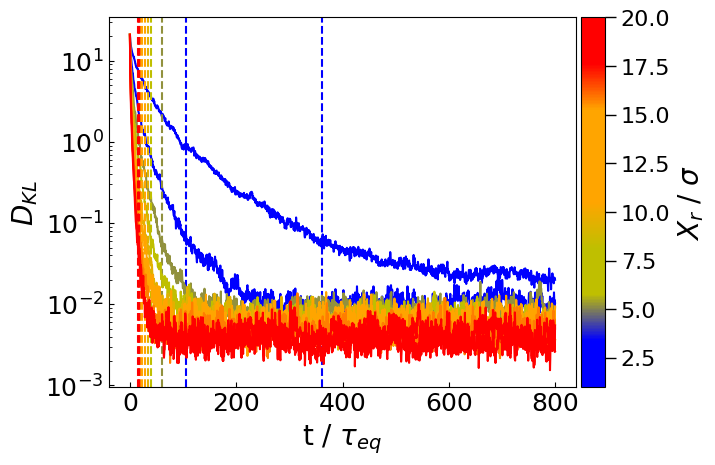

In [69]:
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
timesteps = np.arange(0, steady_state, 5)

platue_indices_per_k = []
for klds_per_batch in KLDs_per_BK_boltz:
    platue_index_per_k = []
    kld_thresholds = []
    for kld_per_time in klds_per_batch:
        kld_threshold = np.mean(kld_per_time[-100:])
        kld_threshold_std = np.std(kld_per_time[-100:])
        kld_threshold = kld_threshold + 10*kld_threshold_std
        kld_thresholds.append(kld_threshold)
    kld_threshold = np.max(kld_thresholds)
    print('KLD threshold:', kld_threshold)
    for kld_per_time, k, c in zip(klds_per_batch, k_harms, colors):
        platue_index = np.where(kld_per_time < kld_threshold)[0][0]
        timestep_platue = timesteps[platue_index]*dt
        platue_index_per_k.append(timestep_platue)
    platue_indices_per_k.append(platue_index_per_k)
platue_indices_per_k = np.array(platue_indices_per_k)
mean_platue_indices_per_k_boltz = np.mean(platue_indices_per_k, axis=0)
std_platue_indices_per_k_boltz = np.std(platue_indices_per_k, axis=0)
k_to_print = k_harms
for kld_per_time, platue, c, typical_relaxation_time in zip(KLDs_per_k_boltz, mean_platue_indices_per_k_boltz, colors,typical_relaxation_times):
    adjusted_timesteps = timesteps*dt
    im=ax.plot(adjusted_timesteps,kld_per_time, color=c)
    im=ax.axvline(platue, color=c, linestyle='--')
cbar = fig.colorbar(cpick, cax=cax, label='Resetting Position', orientation='vertical',ticklocation='right')
cbar.ax.tick_params(labelsize=16, direction='out', length=8, width=1)
cbar.ax.set_ylabel('$X_r$ / $\\sigma$', fontsize=20)
kld_line_handle = plt.Line2D([0],[0],linestyle='-',color='Black', label='KLD')
platue_index_handle = plt.Line2D([0],[0],linestyle='--',color='Black', label=f'$\\tau_R$')
resetting_rate_handles = []
for k, c in zip(k_harms, colors):
    h = plt.bar([0],[0],color=c,label=f'$k$={k:.3f}')
    resetting_rate_handles.append(h)
handles = [kld_line_handle, platue_index_handle] + resetting_rate_handles
ax.set_xlabel('t / $\\tau_{eq}$ ', fontsize=20)
ax.set_ylabel('$D_{KL}$',fontsize=20)
ax.tick_params(axis='both', which='both', labelsize=18, direction='in')
ax.set_yscale('log')
plt.show()

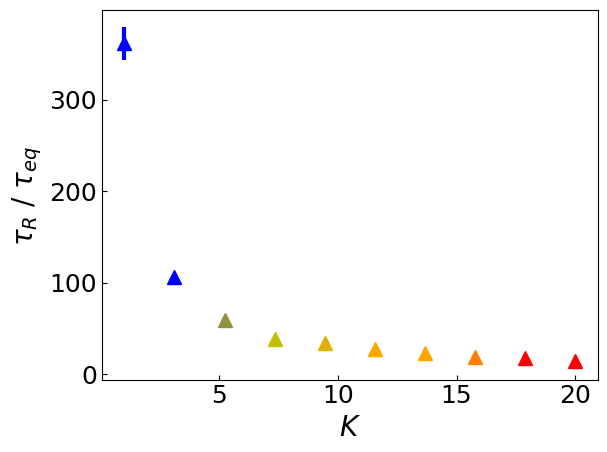

In [70]:
for i, k in enumerate(k_harms):
    plt.errorbar(k, mean_platue_indices_per_k_boltz[i], yerr=std_platue_indices_per_k_boltz[i], linestyle='--', marker = '^', lw=3, ms=10, color=colors[i])
plt.xlabel('$K$', fontsize=20)
plt.ylabel('$\\tau_R$ / $\\tau_{eq}$ ', fontsize=20)
plt.tick_params(axis='both', which='both', labelsize=18, direction='in')
figname = 'c - Relaxation by stiffness - Harmonic - Boltzmann and resetting - normalized.png'
path = os.path.join('..', 'FasterByResetting-Figures/Figure3',figname)
#plt.savefig(path,bbox_inches='tight',format='png', dpi=500)
plt.show()

In [71]:
np.save(external_folder+f'/mean_platue_indices_per_K_boltz.npy', mean_platue_indices_per_k_boltz)
np.save(external_folder+f'/std_platue_indices_per_K_boltz.npy', std_platue_indices_per_k_boltz)
np.save(external_folder+f'/k_harms.npy', np.array(k_harms))

### Join boltz+resetting

In [72]:
import mpl_toolkits.axes_grid1 as axes_grid
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Make a user-defined colormap.
cm1 = mcol.LinearSegmentedColormap.from_list("MyCmapName",["b",'purple',"r"])

# Make a normalizer that will map the time values from
# [start_time,end_time+1] -> [0,1].
cnorm = mcol.Normalize(vmin=min(np.abs(k_harms)),vmax=max(np.abs(k_harms)))
# Turn these into an object that can be used to map time values to colors and
# can be passed to plt.colorbar().
cpick = cm.ScalarMappable(norm=cnorm,cmap=cm1)
colors = [cpick.to_rgba(np.abs(start_pos)) for start_pos in k_harms]


In [74]:
folder = f'HarmonicPotentialTrajectories/K-{k_harms_str}'
if external_drive_path is not None:
    external_folder_resetting = os.path.join(external_drive_path, folder)
else:
    external_folder_resetting = folder
mean_platue_indices_per_r = np.load(external_folder_resetting+f'/mean_platue_indices_per_K.npy')
std_platue_indices_per_r = np.load(external_folder_resetting+f'/std_platue_indices_per_K.npy')
k_harms = np.load(folder+f'/k_harms.npy')
folder_boltz = f'HarmonicPotentialTrajectories/K_r_0-{k_harms_str}'
if external_drive_path is not None:
    external_folder_boltz = os.path.join(external_drive_path, folder_boltz)
else:
    external_folder_boltz = folder_boltz
std_platue_indices_per_k_boltz = np.load(external_folder_boltz+f'/std_platue_indices_per_K_boltz.npy')
mean_platue_indices_per_k_boltz = np.load(external_folder_boltz+f'/mean_platue_indices_per_K_boltz.npy')

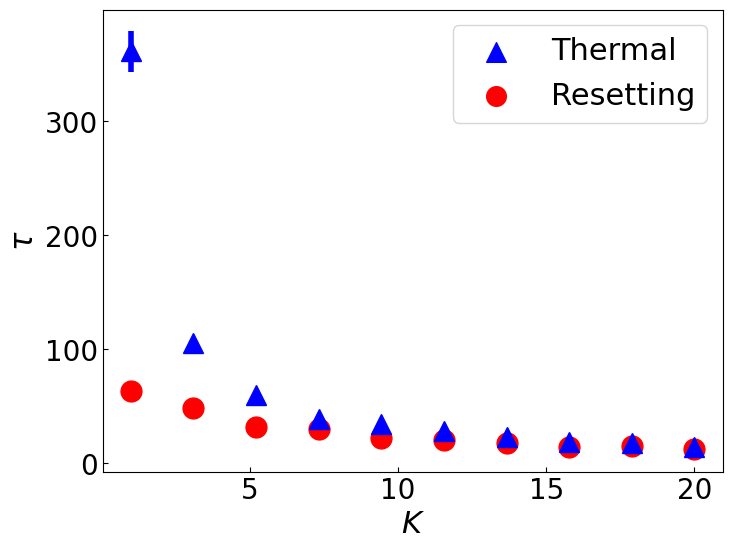

In [76]:
fig, ax  = plt.subplots(figsize=(8, 6))
for i, k in enumerate(k_harms):
    ax.errorbar(k_harms[i], mean_platue_indices_per_r[i], yerr=std_platue_indices_per_r[i], linestyle='--', marker = 'o', lw=4, ms=15, color='r')
    ax.errorbar(k_harms[i], mean_platue_indices_per_k_boltz[i], yerr=std_platue_indices_per_k_boltz[i], linestyle='--', marker = '^', lw=4, ms=15, color='b')
ax.set_xlabel('$K$', fontsize=22)
ax.set_ylabel('$\\tau$', fontsize=22)
ax.tick_params(axis='both', which='both', labelsize=20, direction='in')
figname = 'b - Relaxation by stiffness - Harmonic - normalized.png'
path = os.path.join('..', 'FasterByResetting-Figures/Figure3',figname)
legned_handels = []
boltz_handle = plt.scatter([],[], marker='^', color='blue', label='Thermal', s =200)
resetting_handle = plt.scatter([],[], marker='o', color='r', label='Resetting', s=200)
legned_handels.append(boltz_handle)
legned_handels.append(resetting_handle)
ax.legend(handles=legned_handels, loc='upper right', fontsize=22)
#plt.xscale('log')
#plt.yscale('log')
#plt.savefig(path,bbox_inches='tight',format='png', dpi=500)
plt.show()